# The Oslo Model (Self-organized Criticality)

In [1]:
from OsloModel import OsloModel
from OsloModelNumba import OsloModelNumba
from matplotlib import pyplot as plt
import numpy as np
import numba as nb
import timeit
from time import time

In [2]:
L = 100
grains = 1000

In [3]:
%%timeit
OsloModel(L=L, grains=grains)

2.05 µs ± 46.8 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)


In [4]:
%%timeit
OsloModelNumba(L=L, grains=grains)

The slowest run took 5.47 times longer than the fastest. This could mean that an intermediate result is being cached.
18.5 µs ± 16.6 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [5]:
model = OsloModel(L=L, grains=grains)
modelNumba = OsloModelNumba(L=L, grains=grains)

In [6]:
%%timeit
model.add_all_grains(random_increment=True)

5.26 s ± 70.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [7]:
%%timeit
modelNumba.add_all_grains(True)

5.27 ms ± 110 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


# Avalanche size in function of time

In [8]:
L = 2000
grains = 4000
random_increment = True
modelNumba = OsloModelNumba(L=L, grains=grains)

In [9]:
start_time = time()
modelNumba.add_all_grains(random_increment)
stop_time = time()
time_delta = stop_time - start_time
time_delta

4.514001369476318

In [10]:
steps, avalanche = modelNumba.get_plot_data()
print(len(steps), len(avalanche))

4000 4000


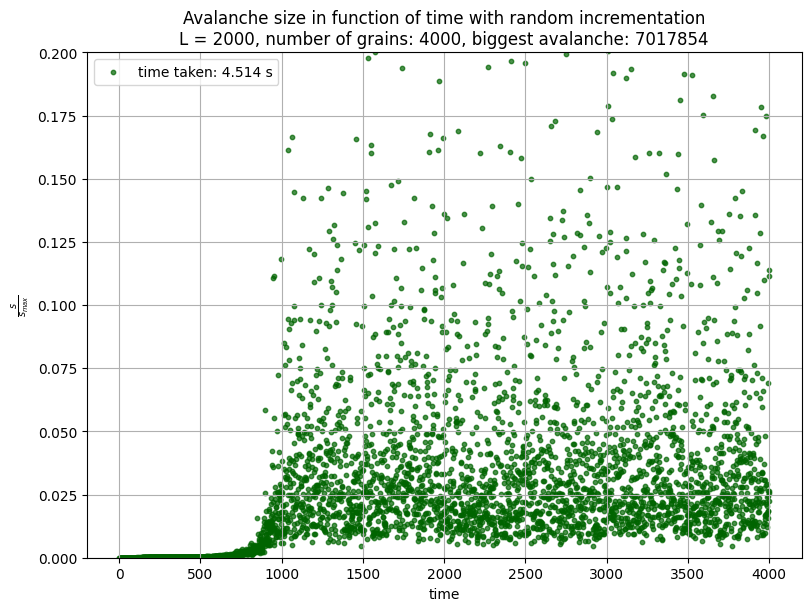

In [11]:
figure1, axes1 = plt.subplots(layout='constrained', figsize=(8, 6))
axes1.scatter(steps, avalanche / avalanche.max(), 
             label=f'time taken: {time_delta:.3f} s',
             s=10,
             alpha=.7,
             color='darkgreen')
axes1.set(title=f'Avalanche size in function of time with random incrementation\n'
               f'L = {L}, number of grains: {grains}, biggest avalanche: {avalanche.max()}',
         xlabel='time',
         ylabel=r'$\frac{s}{s_{max}}$',
         ylim=[0, .2])
axes1.grid()
axes1.legend(loc='upper left')

In [12]:
figure1.savefig(f'AvalancheSizeRandomL{L}G{grains}.png')

In [13]:
L = 4000
grains = 8000
random_increment = False
modelNumba = OsloModelNumba(L=L, grains=grains)

start_time = time()
modelNumba.add_all_grains(random_increment)
stop_time = time()
time_delta = stop_time - start_time
steps, avalanche = modelNumba.get_plot_data()

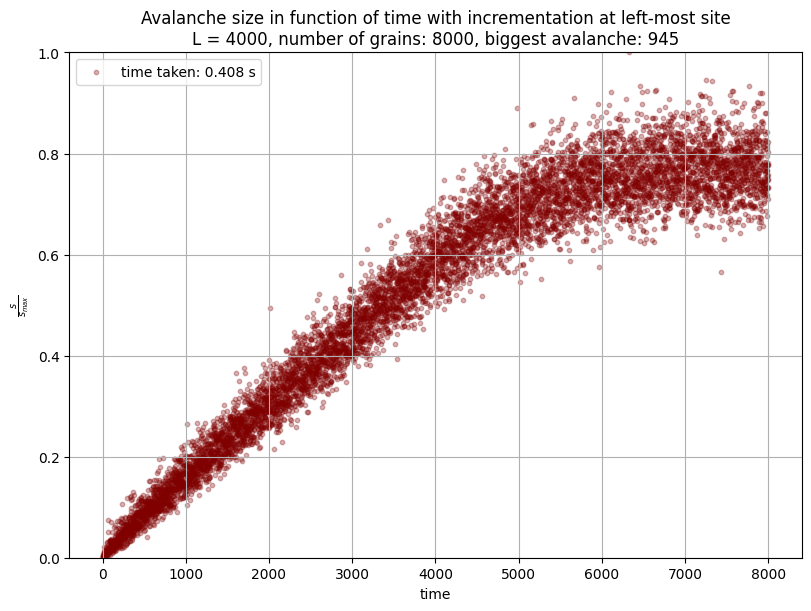

In [14]:
figure2, axes2 = plt.subplots(layout='constrained', figsize=(8, 6))
axes2.scatter(steps, avalanche / avalanche.max(), 
             label=f'time taken: {time_delta:.3f} s',
             s=10,
             alpha=.3,
             color='maroon')
axes2.set(title=f'Avalanche size in function of time with incrementation at left-most site\n'
               f'L = {L}, number of grains: {grains}, biggest avalanche: {avalanche.max()}',
         xlabel='time',
         ylabel=r'$\frac{s}{s_{max}}$',
         ylim=[0, 1])
axes2.grid()
axes2.legend(loc='upper left')

In [15]:
figure2.savefig(f'AvalancheSizeLeftmostL{L}G{grains}.png')

## We can also notice a sinusoidal behavior for larger number of grains

In [16]:
L = 1000
grains = 20000
random_increment = False
modelNumba = OsloModelNumba(L=L, grains=grains)

start_time = time()
modelNumba.add_all_grains(random_increment)
stop_time = time()
time_delta = stop_time - start_time
steps, avalanche = modelNumba.get_plot_data()

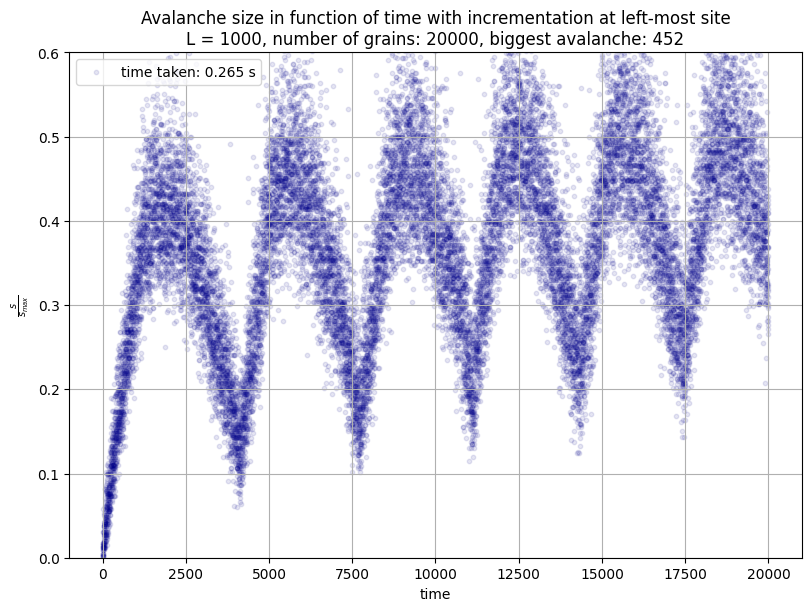

In [17]:
figure3, axes3 = plt.subplots(layout='constrained', figsize=(8, 6))
axes3.scatter(steps, avalanche / avalanche.max(), 
             label=f'time taken: {time_delta:.3f} s',
             s=10,
             alpha=.1,
             color='darkblue')
axes3.set(title=f'Avalanche size in function of time with incrementation at left-most site\n'
               f'L = {L}, number of grains: {grains}, biggest avalanche: {avalanche.max()}',
         xlabel='time',
         ylabel=r'$\frac{s}{s_{max}}$',
         ylim=[0, .6])
axes3.grid()
axes3.legend(loc='upper left')

In [18]:
figure3.savefig(f'AvalancheSizeLeftmostL{L}G{grains}.png')

# Avalanche size probability

In [19]:
@nb.njit()
def add_vectors(vector1: nb.int32[:], vector2: nb.int32[:]) -> nb.int32[:]:
    if len(vector1) > len(vector2):
        vector3 = vector1.copy()
        vector3[:len(vector2)] += vector2
    else:
        vector3 = vector2.copy()
        vector3[:len(vector1)] += vector1
    return vector3

In [20]:
def calculate_avalanche_probabilities(L, grains, trials, random_increment):
    osloModel = OsloModelNumba(L=L, grains=grains)
    avalanche_count = np.array([]).astype(np.int32)
    for trial in range(trials):
        osloModel.add_all_grains(random_increment)
        steps, avalanche = osloModel.get_plot_data()
        avalanche_count = add_vectors(avalanche_count, np.bincount(avalanche).astype(np.int32))
    return avalanche_count / np.sum(avalanche_count)

In [21]:
%%timeit
calculate_avalanche_probabilities(400, 2000, 10, False)

98.6 ms ± 1.34 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [22]:
L_list = [150, 300, 500, 1000, 2000]
grains = 6000
colors = ['maroon', 'darkgreen', 'darkblue', 'gold', 'indigo']
trials = 100
is_incremented_randomly = False

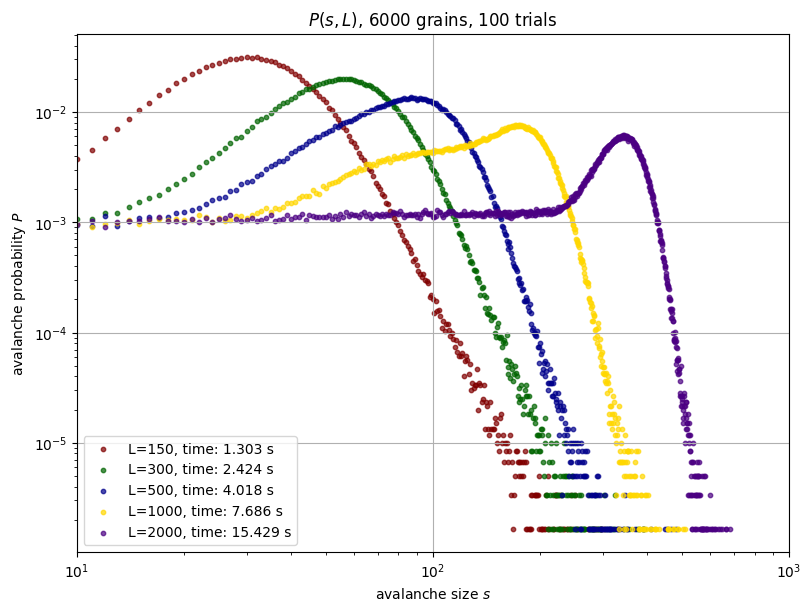

In [23]:
figure4, axes4 = plt.subplots(1, 1, layout='constrained', figsize=(8, 6))
for index, L in enumerate(L_list):
    start_time = time()
    avalanche_count = calculate_avalanche_probabilities(L_list[index], 
                                                        grains, 
                                                        trials, 
                                                        is_incremented_randomly)
    time_delta = time() - start_time
    axes4.scatter(np.arange(len(avalanche_count)), avalanche_count,
                 color=colors[index],
                 s=10,
                 label=f'L={L}, time: {time_delta:.3f} s',
                 alpha=.7)
    axes4.set(title=f'$P(s, L)$, {grains} grains, {trials} trials',
             xlabel='avalanche size $s$',
             ylabel='avalanche probability $P$',
             xscale='log', yscale='log',
             xlim=[10, 1000])
    axes4.legend(loc='lower left')
    axes4.grid()

In [24]:
figure4.savefig(f'AvalancheProbabilityLeftmostL{L}G{grains}T{trials}.png')